In [1]:
from sklearn.datasets import make_moons
import numpy as np
import os
import tensorflow as tf

tf.set_random_seed(100)
np.random.seed(100)

m = 1000
X, y = make_moons(m, noise = 0.07, random_state = 100)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
X.shape

(1000, 2)

In [4]:
y.shape

(1000,)

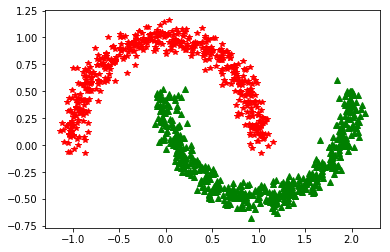

In [5]:
plt.plot(X[y == 1, 0], X[y == 1, 1], 'g^', label = 'Class1')
plt.plot(X[y == 0, 0], X[y == 0, 1], 'r*', label = 'Class2')
plt.show()

In [6]:
X_bias = np.c_[np.ones((m, 1)), X]

In [7]:
y = y.reshape(-1, 1)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_bias, y, test_size = 0.2)

In [9]:
def get_batch(X_train, y_train, batch_size):
    index_num = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[index_num]
    y_batch = y_train[index_num]
    return X_batch, y_batch

In [10]:
X_var = tf.placeholder(tf.float32, shape = (None, 2 + 1), name = 'X')
y_var = tf.placeholder(tf.float32, shape = (None, 1), name = 'y')

theta = tf.Variable(tf.random_uniform([2 + 1, 1], -1, 1, seed = 100), name = 'theta')
logits = tf.matmul(X_var, theta, name = 'logits')
y_prob = 1 / (1 + tf.exp(-logits))

In [11]:
y_prob = tf.sigmoid(logits)

In [12]:
loss = tf.losses.log_loss(y_var, y_prob)

In [13]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [14]:
init = tf.global_variables_initializer()

In [15]:
n_epochs = 2001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = get_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X_var: X_batch, y_var: y_batch})
        loss_val = loss.eval({X_var: X_test, y_var: y_test})
        if epoch % 100 == 0:
            print "Epoch:", epoch, "\tLoss:", loss_val

    y_prob_val = y_prob.eval(feed_dict={X_var: X_test, y_var: y_test})

Epoch: 0 	Loss: 0.697985
Epoch: 100 	Loss: 0.325029
Epoch: 200 	Loss: 0.278478
Epoch: 300 	Loss: 0.25902
Epoch: 400 	Loss: 0.248282
Epoch: 500 	Loss: 0.241803
Epoch: 600 	Loss: 0.237306
Epoch: 700 	Loss: 0.234079
Epoch: 800 	Loss: 0.23207
Epoch: 900 	Loss: 0.230655
Epoch: 1000 	Loss: 0.229246
Epoch: 1100 	Loss: 0.228153
Epoch: 1200 	Loss: 0.228235
Epoch: 1300 	Loss: 0.227224
Epoch: 1400 	Loss: 0.226663
Epoch: 1500 	Loss: 0.226339
Epoch: 1600 	Loss: 0.226493
Epoch: 1700 	Loss: 0.226439
Epoch: 1800 	Loss: 0.226082
Epoch: 1900 	Loss: 0.225629
Epoch: 2000 	Loss: 0.225692


In [16]:
y_pred = (y_prob_val >= 0.5)

In [17]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.86170212765957444

In [18]:
recall_score(y_test, y_pred)

0.89010989010989006

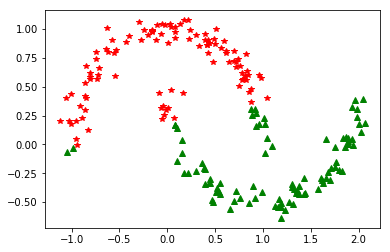

In [19]:
y_pred = y_pred.reshape(-1)
plt.plot(X_test[y_pred == 1, 1], X_test[y_pred == 1, 2], 'g^', label = 'Class1')
plt.plot(X_test[y_pred == 0, 1], X_test[y_pred == 0, 2], 'r*', label = 'Class2')
plt.show()

# Adding Polynomial features

In [20]:
from sklearn.preprocessing import PolynomialFeatures

m = 1000
X, y = make_moons(m, noise = 0.07, random_state = 100)

poly = PolynomialFeatures(3)
X_poly = poly.fit_transform(X)

In [21]:
X_poly.shape

(1000, 10)

In [22]:
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.2)

In [23]:
X_var = tf.placeholder(tf.float32, shape = (None, 9 + 1), name = 'X')
y_var = tf.placeholder(tf.float32, shape = (None, 1), name = 'y')

with tf.name_scope('logistic_reg'):
    initr = tf.random_uniform([10, 1], -1.0, 1.0, seed = 100)
    theta = tf.Variable(initr, name = 'theta')
    logits = tf.matmul(X_var, theta, name = 'logits')
    y_prob = tf.sigmoid(logits)
    
with tf.name_scope('train'):
    loss = tf.losses.log_loss(y_var, y_prob, scope = 'loss')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01)
    training_op = optimizer.minimize(loss)
    loss_summary = tf.summary.scalar('log_loss', loss)

with tf.name_scope('init'):
    init = tf.global_variables_initializer()
    
with tf.name_scope('save'):
    saver = tf.train.Saver()
    
file_writer = tf.summary.FileWriter('/tmp/moons/train_logistic_1', tf.get_default_graph())

In [24]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m/batch_size))

checkpoint_path = '/tmp/train_logistic_model1.ckpt'
checkpoint_epoch_path = checkpoint_path + '.epoch'
final_model_path = '/tmp/final_logistic_model'

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
        
    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = get_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict = {X_var: X_batch, y_var: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X_var: X_test, y_var: y_test})
        file_writer.add_summary(summary_str, epoch)
        
        if epoch % 500 == 0:
            print "Epoch:", epoch, "\tLoss:", loss_val
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_prob_val = y_prob.eval(feed_dict={X_var: X_test, y_var: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.935667
Epoch: 500 	Loss: 0.152586
Epoch: 1000 	Loss: 0.108305
Epoch: 1500 	Loss: 0.0852012
Epoch: 2000 	Loss: 0.0708289
Epoch: 2500 	Loss: 0.0612534
Epoch: 3000 	Loss: 0.0540439
Epoch: 3500 	Loss: 0.0487028
Epoch: 4000 	Loss: 0.0445537
Epoch: 4500 	Loss: 0.0408117
Epoch: 5000 	Loss: 0.0378859
Epoch: 5500 	Loss: 0.0354782
Epoch: 6000 	Loss: 0.0333308
Epoch: 6500 	Loss: 0.0315878
Epoch: 7000 	Loss: 0.030011
Epoch: 7500 	Loss: 0.0285278
Epoch: 8000 	Loss: 0.0271873
Epoch: 8500 	Loss: 0.0260616
Epoch: 9000 	Loss: 0.0249839
Epoch: 9500 	Loss: 0.024016
Epoch: 10000 	Loss: 0.0231768


In [25]:
y_pred = (y_prob_val >= 0.5)

In [26]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

1.0

In [27]:
recall_score(y_test, y_pred)

1.0

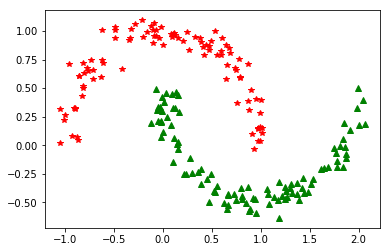

In [28]:
y_pred = y_pred.reshape(-1)
plt.plot(X_test[y_pred == 1, 1], X_test[y_pred == 1, 2], 'g^', label = 'Class1')
plt.plot(X_test[y_pred == 0, 1], X_test[y_pred == 0, 2], 'r*', label = 'Class2')
plt.show()

In [29]:
from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration)

    print "Iteration", search_iteration
    print "\tbatch size:", batch_size
    print "\tlearning_rate:", learning_rate
    print "\ttraining: ",
    
    tf.reset_default_graph()
    tf.set_random_seed(100)
    np.random.seed(100)
    
    X_var = tf.placeholder(tf.float32, shape = (None, 9 + 1), name = 'X')
    y_var = tf.placeholder(tf.float32, shape = (None, 1), name = 'y')
    
    with tf.name_scope('logistic_reg'):
        initr = tf.random_uniform([10, 1], -1.0, 1.0, seed = 100)
        theta = tf.Variable(initr, name = 'theta')
        logits = tf.matmul(X_var, theta, name = 'logits')
        y_prob = tf.sigmoid(logits)

    with tf.name_scope('train_randomCV'):
        loss = tf.losses.log_loss(y_var, y_prob, scope = 'loss')
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
        training_op = optimizer.minimize(loss)
        loss_summary = tf.summary.scalar('log_loss', loss)

    with tf.name_scope('init'):
        init = tf.global_variables_initializer()

    with tf.name_scope('save'):
        saver = tf.train.Saver()

    file_writer = tf.summary.FileWriter('/tmp/moons/train_logistic_2', tf.get_default_graph())
    
    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))

    final_model_path = '/tmp/final_logistic_model' + str(search_iteration)
    
    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = get_batch(X_train, y_train, batch_size)
                sess.run(training_op, feed_dict={X_var: X_batch, y_var: y_batch})
                
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X_var: X_test, y_var: y_test})
            
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print '.',

        saver.save(sess, final_model_path)

        print ''
        y_prob_val = y_prob.eval(feed_dict={X_var: X_test, y_var: y_test})
        y_pred = (y_prob_val >= 0.5)
        
        print "\tprecision:", precision_score(y_test, y_pred)
        print "\trecall:", recall_score(y_test, y_pred)

Iteration 0
	batch size: 9
	learning_rate: 0.00443037524522
	training:  . . . . . . . . . . . . . . . . . . . . . 
	precision: 1.0
	recall: 1.0
Iteration 1
	batch size: 90
	learning_rate: 0.00178264971514
	training:  . . . . . . . . . . . . . . . . . . . . . 
	precision: 0.97
	recall: 0.950980392157
Iteration 2
	batch size: 52
	learning_rate: 0.00203228544324
	training:  . . . . . . . . . . . . . . . . . . . . . 
	precision: 0.990196078431
	recall: 0.990196078431
Iteration 3
	batch size: 94
	learning_rate: 0.00449152382514
	training:  . . . . . . . . . . . . . . . . . . . . . 
	precision: 0.990291262136
	recall: 1.0
Iteration 4
	batch size: 38
	learning_rate: 0.0796323472178
	training:  . . . . . . . . . . . . . . . . . . . . . 
	precision: 1.0
	recall: 1.0
Iteration 5
	batch size: 94
	learning_rate: 0.000463425058329
	training:  . . . . . . . . . . . . . . . . . . . . . 
	precision: 0.90625
	recall: 0.852941176471
Iteration 6
	batch size: 38
	learning_rate: 0.0477068184194
	training: 